# Corpus semantic & syntactic analysis
In this notebooks, I'll explore the following analyses of corpus semantics and syntactics:
1. **Vocabulary analysis.** Look for out-of-vocabulary words in each pairwise comparison of corpora. The more out-of-vocabulary words for a given pair, the less similar they are to one another. Expect that SciERC and PICKLE will have more overlapping vocabulary.
2. **Token analysis.** Using a word2vec model, embed the tokens from each corpus, and see how they cluster in the vector space. Expect that PICKLE and SciERC tokens will cluster together in space.
3. **Document analysis.** Using some kind of document embedding (doc2vec, a BERT based embedding, etc), perform the same style of analysis as for the tokens. Expect PICKLE and SciERC documents to cluster together more often.

In [1]:
from gensim.models import KeyedVectors
import jsonlines
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Importing my own Dataset class
import sys
sys.path.append('../models/corpus_comparison/')
from dataset import Dataset

## 1. Vocabulary analysis
For this analysis, we'll use the SciERC, GENIA, and PICKLE corpora to get the sets of tokens that make up the three corpora. We'll then look for out-of-vocabulary words in each pairwise comparison of corpora. Based on the pre-trained model results, in which SciERC outperformed GENIA on the PICKLE corpus, we expect to see that there are more out-of-vocabulary words in the GENIA-PICKLE comparison than in the SciERC-PICKLE comparison.
### Getting our corpus vocabularies
First, we have to get the GENIA and SciERC datasets.

#### Downloading SciERC and GENIA data
We'll use the code provided in the [DyGIE++](https://github.com/dwadden/dygiepp) repo for this purpose, running the following commands from the root of the `dygiepp` repo:

```
bash ./scripts/data/get_scierc.sh
```

```
bash ./scripts/data/get_genia.sh
```

### Comparing vocabularies
Now that we have all three datasets, we can compare them. This is done with the script `out_of_vocab_comparison.py`, found in the `models/corpus_comparison` directory.

<br>

*A summary of the comparisons:* For each pair of datasets, a total of 6 metrics were calculated. For each of unigrams, bigrams, and trigrams, the datasets were compared in both directions, and the number of out-of-vocabulary words for that comparison were computed. In order to be able to compare the differences between PICKLE/GENIA and PICKLE/SciERC, the comparisons were normalized by the number of words of that n-gram length in the comparison corpus, making the final calculation equivalent to:

```len(set(ngrams in PICKLE) - set(ngrams in GENIA/SciERC)) / len(ngrams in GENIA/SciERC)```

#### Commands used to generate comparisons
The relative paths here are specific to my local filesystem/data directory structure, which doesn't come along with this repository. These commands were run form the `models/corpus_comparison/` directory.

To compare GENIA to PICKLE:
```
python out_of_vocab_comparison.py pickle ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_FOR_EVALUATION_ent_and_rel_all_gold_std_abstracts_08Nov2022.jsonl genia ../../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json  ../../data/straying_off_topic_data/corpus_comparison/ pickle_vs_genia_normalized -v
```

To compare SciERC to PICKLE:
```
python out_of_vocab_comparison.py pickle ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_FOR_EVALUATION_ent_and_rel_all_gold_std_abstracts_08Nov2022.jsonl scierc ../../../dygiepp/data/scierc/processed_data/json/train.json  ../../data/straying_off_topic_data/corpus_comparison/ pickle_vs_scierc_normalized -v
```

#### Looking at comparison outputs
Now, lets read in the data and see what the situation is.

In [6]:
genia_vs_pickle_path = '../data/straying_off_topic_data/corpus_comparison/pickle_vs_genia_normalized_oov_comparison.jsonl'
scierc_vs_pickle_path = '../data/straying_off_topic_data/corpus_comparison/pickle_vs_scierc_normalized_oov_comparison.jsonl'

In [7]:
genia_vs_pickle = []
with jsonlines.open(genia_vs_pickle_path) as reader:
    for obj in reader:
        genia_vs_pickle.append(obj)
        
scierc_vs_pickle = []
with jsonlines.open(scierc_vs_pickle_path) as reader:
    for obj in reader:
        scierc_vs_pickle.append(obj)

To better visualize the situation, let's make a bar plot!

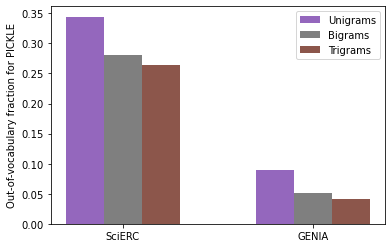

In [11]:
pickle_labels = ['SciERC', 'GENIA']
unigrams = [scierc_vs_pickle[0]['unigrams_oov_pickle_frac'], genia_vs_pickle[0]['unigrams_oov_pickle_frac']]
bigrams = [scierc_vs_pickle[0]['bigrams_oov_pickle_frac'], genia_vs_pickle[0]['bigrams_oov_pickle_frac']]
trigrams = [scierc_vs_pickle[0]['trigrams_oov_pickle_frac'], genia_vs_pickle[0]['trigrams_oov_pickle_frac']]

x = np.arange(len(pickle_labels))
x = 0.5*x
width = 0.1

#fig, ax = plt.subplots()
plt.bar(x - width, unigrams, width, color='tab:purple', label='Unigrams')
plt.bar(x, bigrams, width, color='tab:grey', label='Bigrams')
plt.bar(x + width, trigrams, width, color='tab:brown', label='Trigrams')

plt.ylabel('Out-of-vocabulary fraction for PICKLE')
plt.xticks(x, pickle_labels)
plt.legend(loc='upper right')

plt.savefig('../data/straying_off_topic_data/corpus_comparison/figures/oov_plot.png', bbox_inches='tight', dpi=300)

In all three categories, the amount of PICKLE's vocabulary that is out of the vocabulary of the other corpus is much greater for SciERC than for GENIA. This is the opposite of what we expected, since SciERC performs better for entity recognition on the PICKLE corpus than GENIA does. However, it's possible that the semantics of the words in SciERC are more similar to those in PICKLE than in GENIA, which could account for the phenomenon. That's what we'll look at next.

-----------
## Token Analysis
Now, lets generate word vectors for the unigram, bigram, and trigram tokens in the three corpora, and compare their semantics by looking at how those vectors cluster.

<br>

We'll use the script `models/corpus_comparison/train_word2vec.py` to generate these word vectors, and read them in here. This script uses all the uni-, bi-, and trigrams from all three corpora to train a new Word2Vec model using the [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html).

### Code to generate the word vectors
The following command was used to generate the word vectors:
```
python train_word2vec.py -corpora ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl ../../../dygiepp/data/scierc/processed_data/json/train.json ../../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json -out_loc ../../data/straying_off_topic_data/corpus_comparison/ -out_prefix pickle_scierc_genia_combined -v
```

### Reading in and plotting the word vectors
Now we want to take a look at the differences between the vectors from the different corpora. In order to do this, we're going to read them in, sort them to the corpus from which they came, and then using PCA to generate 2-D versions of the vectors that we can visualize.

In [ ]:
# Import the word vectors
word2vecs = '../data/straying_off_topic_data/corpus_comparison/pickle_scierc_genia_combined_word2vec_skipgram.wordvectors'
vecs = KeyedVectors.load(word2vecs)

In [ ]:
# Import the datasets
def read_dataset(path, name):
    """
    Read in a dataset to a Dataset object.
    """
    objs = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            objs.append(obj)
            
    dset = Dataset(name, objs)
    
    return dset

In [ ]:
scierc_path = '../../dygiepp/data/scierc/processed_data/json/train.json'
genia_path = '../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json'
pickle_path = '../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl'

scierc = read_dataset(scierc_path, 'scierc')
genia = read_dataset(genia_path, 'genia')
pickle = read_dataset(pickle_path, 'pickle')

In [ ]:
# Sort vectors
# Heads up that this is slow
sep_vecs = {}
for dset in [scierc, genia, pickle]:
    _ = dset.get_dataset_vocab()
    dset_comb_vocab = list(dset.vocab['unigrams']) + list(dset.vocab['bigrams']) + list(dset.vocab['trigrams'])
    dset_vecs = {k:vecs[k] for k in vecs.index_to_key if k in dset_comb_vocab}
    sep_vecs[dset.get_dataset_name()] = dset_vecs

Legend solution in below code is from [this stackoverflow answer](https://stackoverflow.com/a/31311862/13340814)

In [ ]:
# Do PCA to get plottable shaped vectors
# Fit on all the vectors, then transform each individually to keep the sorted structure

# Make input array
X = []
for k in vecs.index_to_key:
    X.append(vecs[k])

# Fit PCA
pca = PCA(n_components=2)
pca.fit(X)

# Transform the vectors
x, y, group = [], [], []
for dset in sep_vecs:
    for word in sep_vecs[dset]:
        word_vec = sep_vecs[dset][word].reshape(1, -1)
        transformed = pca.transform(word_vec).flatten()
        x.append(transformed[0])
        y.append(transformed[1])
        group.append(dset)
        
# Plot
color_dict = {'scierc': 'blue', 'genia':'orange', 'pickle':'green'}
colors = [color_dict[i] for i in group]
scatter = plt.scatter(x=x, y=y, c=colors, alpha = 0.5, s=4)
plt.xlabel('PC1')
plt.ylabel('PC2')
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)

plt.savefig('../data/straying_off_topic_data/corpus_comparison/figures/full_corpus_wordvec_compare.png', bbox_inches='tight', dpi=300)

### Further exploration of word vectors with clustering
Generally speaking, it looks like all three corpora form two clusters. There are no telling visual differences between the three corpora here, but it might be helpful to see what typical words from those two clusters look like for each of the corpora. In orer to do this, we'll use K-Means clustering with k=2 for each of the three corpoora. We can then draw random words from each cluster, as well as compute the distance between the centroids of each cluster, for all three corpora.

In [ ]:
# Pre-process the data
cluster_prep = {}
for dset in sep_vecs:
    vec_df = pd.DataFrame.from_dict(sep_vecs[dset], orient='index')
    cluster_prep[dset] = vec_df

In [ ]:
# Run clustering alg to get cluster labels for all rows in df
def get_clusters(cluster_prep, k=2):
    """
    Get cluster labels and centroid for each dataset.
    
    parameters:
        cluster_prep, dict: keys are dset names, values are arrays of vectors
        k, int: number of clusters
    """
    clusters = {}
    centroids = {}
    for dset in cluster_prep:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(cluster_prep[dset])
        preds = kmeans.predict(cluster_prep[dset])
        pred_df = pd.DataFrame({'word': cluster_prep[dset].index, 'cluster': preds})
        clusters[dset] = pred_df
        centroids[dset] = kmeans.cluster_centers_
        
    return clusters, centroids

In [ ]:
clusters_2, centroids_2 = get_clusters(cluster_prep, k=2)

Now that we have our clusters, let's make three separate plots, one for each dataset, where the two clusters are colored differently, with their centroids marked with a large red dot. This means we have to do PCA again to get the plottable forms. We still want to fit the PCA on all three datasets together, so the resulting plots are comparable, but we then want to separate out the three datasets into different plots, and use the cluster labels to color them instead.

In [ ]:
# Do PCA to get plottable shaped vectors
# Fit on all the vectors, then transform each individually to keep the sorted structure

def plot_clusters(vecs, cluster_prep, clusters, centroids, color_dict):
    """
    Plot clusters.
    
    parameters:
        vecs, KeyedVector obj: original vector object
        cluster_prep, dict: keys are dset names, values are arrays of vectors
        clusters, dict: keys are dset names, values are df with word as idx and cluster number as column
        centroids, dict: keys are dset names, values are arrays with centroids
        color_dict, dict: keys are cluster labels, values are colors
    """
    # Make input array
    X = []
    for k in vecs.index_to_key:
        X.append(vecs[k])

    # Fit PCA
    pca = PCA(n_components=2)
    pca.fit(X)

    # Make fig
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(4, 9))
    fig.supxlabel('PC1')
    fig.supylabel('PC2')
    plt.subplots_adjust(bottom=0.1, left=0.2)
    
    # Transform the vectors and plot
    for dset, ax in zip(cluster_prep.keys(), axs):
        # Word vectors
        x, y, cluster = [], [], []
        for i in range(cluster_prep[dset].shape[0]):
            word_vec = cluster_prep[dset].iloc[i].to_numpy().reshape(1, -1)
            transformed = pca.transform(word_vec).flatten()
            x.append(transformed[0])
            y.append(transformed[1])
            cluster.append(clusters[dset].iloc[i].values[1])

        # Centroids
        centroid_arr = centroids[dset]
        x_centr, y_centr = [], []
        for row in centroid_arr:
            sample = row.reshape(1, -1)
            transformed = pca.transform(sample).flatten()
            x_centr.append(transformed[0])
            y_centr.append(transformed[1])

        # Plot
        colors = [color_dict[i] for i in cluster]
        ax.scatter(x=x, y=y, c=colors, alpha = 0.5, s=4)
        ax.scatter(x=x_centr, y=y_centr, c='red', s=20)
        ax.set_title(dset)

    plt.savefig(f'../data/straying_off_topic_data/corpus_comparison/figures/k{len(color_dict.keys())}_clusters_sep_dsets.png', bbox_inches='tight', dpi=300)

In [ ]:
# k = 2
color_dict_2 = {0: 'blue', 1:'orange'}
plot_clusters(vecs, cluster_prep, clusters_2, centroids_2, color_dict_2)

These plots actually make it look like there are 3 clusters, and k=2 isn't the correct choice.  The yellow cluster, in all 3 datasets, is clearly two clusters. Lets try that again, but with k=3:

In [ ]:
# k = 3
clusters_3, centroids_3 = get_clusters(cluster_prep, k=3)
color_dict_3 = {0: 'blue', 1:'orange', 2:'cyan'}
plot_clusters(vecs, cluster_prep, clusters_3, centroids_3, color_dict_3)

Interestingly enough, PICKLE clusters differently than the other two corpora, looking more like it should maybe have 4 clusters instead of 3. However, I am inclined to believe that this is a consequence of the fact that PICKLE is so much smaller than the other two corpora.

TODO: Look at random words from each cluster.

### Wordvectors for unique words only
Another approach to dig into what's going on here is to make the same plots as above (all three datsets together, each of the three datasets but clustered), but only using the words that each corpus contains uniquely of the other two. For example, what words are there in PICKLE that don't appear in either SciERC or GENIA? I would expect that the three corpora would form separate clusters, but with the semantic (euclidian) distance between the clusters for SciERC and PICKLE being less than the distance between GENIA and PICKLE. This rests on the assumption that a model will perform better on a new domain if the out-of-vocabulary words in the new domain are close to its own unique words.

In [ ]:
# Use set difference to get unique words form sep_vecs
unique_sep_vecs = {}
for dset in sep_vecs:
    other_dset_names = [d for d in sep_vecs if dset != d]
    other_dset_set = set(list(sep_vecs[other_dset_names[0]].keys()) + list(sep_vecs[other_dset_names[1]].keys()))
    dset_set = set(list(sep_vecs[dset].keys()))
    diff = dset_set.difference(other_dset_set)
    un_vecs = {w:v for w, v in sep_vecs[dset].items() if w in diff}
    unique_sep_vecs[dset] = un_vecs

In [ ]:
# Do PCA to get plottable shaped vectors
# Fit on all the vectors, then transform each individually to keep the sorted structure

# Make input array
X = []
for k in vecs.index_to_key:
    X.append(vecs[k])

# Fit PCA
pca = PCA(n_components=2)
pca.fit(X)

# Transform the vectors
x, y, group = [], [], []
for dset in unique_sep_vecs:
    for word in unique_sep_vecs[dset]:
        word_vec = unique_sep_vecs[dset][word].reshape(1, -1)
        transformed = pca.transform(word_vec).flatten()
        x.append(transformed[0])
        y.append(transformed[1])
        group.append(dset)
        
# Plot
color_dict = {'scierc': 'blue', 'genia':'orange', 'pickle':'green'}
colors = [color_dict[i] for i in group]
scatter = plt.scatter(x=x, y=y, c=colors, alpha = 0.5, s=4)
plt.xlabel('PC1')
plt.ylabel('PC2')
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)

plt.savefig('../data/straying_off_topic_data/corpus_comparison/figures/unique_words_scatter.png', bbox_inches='tight', dpi=300)

Whilst that doesn't correspond to my expectation, I do think that it looks like the PICKLE and SciERC unique words more frequently fall near each other in space, and that there are more "distracting" words in the GENIA unique words set. To test this, let's look at [some distance metrics](https://online.stat.psu.edu/stat505/lesson/14/14.4) used to compute the distance between clusters (we'll look at single, complete and average linkage). Here, we'll consider each dataset's unique word vectors to be a cluster, as those are the groupings we're interested in.

In [ ]:
# Set up dfs to get differences
unique_dfs = {}
for dset in unique_sep_vecs:
    df = pd.DataFrame.from_dict(unique_sep_vecs[dset], orient='index')
    unique_dfs[dset] = df

In [ ]:
# Calculate raw differences
distance_matrices = {}
for pair in [('scierc', 'genia'), ('scierc', 'pickle'), ('genia', 'pickle')]:
    dist = euclidean_distances(unique_dfs[pair[0]], unique_dfs[pair[1]])
    distance_matrices[f'{pair[0]}_{pair[1]}'] = dist

Each matrix has unique values on both the x and y axes, so every comparison (value in the matrix) represents a unique pair. We can now get the max, min and average distance for each dataset:

In [ ]:
pair_metrics = {}
for pair in distance_matrices:
    min_dist = distance_matrices[pair].min() # Single linkage
    max_dist = distance_matrices[pair].max() # Complete linkage
    mean_dist = distance_matrices[pair].mean() # Average linkage
    pair_metrics[pair] = (min_dist, max_dist, mean_dist)

In [ ]:
pair_metrics

Now let's make a bar plot to easily visualize these distances for the comparisons to PICKLE:

In [ ]:
pair_labels = ['SciERC', 'GENIA']
single = [pair_metrics['scierc_pickle'][0], pair_metrics['genia_pickle'][0]]
complete = [pair_metrics['scierc_pickle'][1], pair_metrics['genia_pickle'][1]]
average = [pair_metrics['scierc_pickle'][2], pair_metrics['genia_pickle'][2]]

x = np.arange(len(pair_labels))
x = 0.5*x
width = 0.1

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, single, width, color='tab:pink', label='Single Linkage')
rects2 = ax.bar(x, complete, width, color='tab:olive', label='Complete Linkage')
rects3 = ax.bar(x + width, average, width, color='tab:cyan', label='Average Linkage')

ax.set_ylabel('Linkage Distance')
ax.set_xticks(x, pair_labels)
ax.legend()

fig.tight_layout()

plt.savefig('../data/straying_off_topic_data/corpus_comparison/figures/linkage_distances.png', bbox_inches='tight', dpi=300)

This conforms with our expectation! If we look at the printout of the distances, we can see that the single linkage is slightly less for GENIA than for SciERC. However, the complete and average linkages are less for SciERC than they are for GENIA! This aligns with the idea that GENIA has a greater variety of words which "distract" the model from being able to perform well on PICKLE.